In [1]:
import os
import folium
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer
from langdetect import detect
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle as pk

In [2]:
#function to create clusters for the coordinates
def create_clusters(df, lat_col, lng_col, num_clusters):
    # Get the coordinates as a numpy array
    coordinates = df[[lat_col, lng_col]].values.tolist()

    # Create the KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    # Fit the model and get the cluster labels
    df['group'] = kmeans.fit_predict(coordinates)
    df['group_centroid_lng'] = df['group'].apply(lambda x: kmeans.cluster_centers_[:, 1][x])
    df['group_centroid_lat'] = df['group'].apply(lambda x: kmeans.cluster_centers_[:, 0][x])

    # Return the dataframe with the additional 'group' column
    return df

#language detection using langdetect
def get_language_label(text):
    try:
        lang = detect(text)
        if lang == 'en':
            return 0
        elif lang == 'es':
            return 1
        else:
            return 2
    except:
        return 2
#username encoder
def encode_user_id(df, user_id_col, id_col):
    # Create a label encoder object
    le = LabelEncoder()

    # Label encode the user_id column
    df[user_id_col] = le.fit_transform(df[user_id_col])

    # Drop the id column
    df = df.drop(columns=[id_col])

    # Return the modified dataframe
    return df


#use langid to detect language
import langid

def get_language_label2(text):
    try:
        lang = langid.classify(text)[0]
        if lang == 'en':
            return '0'
        else:
            return '1'
    except:
        return '1'

class GlobalScaler():
	def __init__(self):
		self.means = None
		self.stddev = None

	def fit_transform(self, data):
		self.means = np.mean(data, axis=0)
		centereddata = data - self.means
		self.stddev = np.std(centereddata)
		return centereddata / self.stddev

	def transform(self, data):
		return (data - self.means) / self.stddev

	def inverse_transform(self, data):
		return (np.asarray(data) * self.stddev) + self.means

In [3]:
df_1 = pd.read_csv('original_datasets/Clusters_Coordinates.csv')
df_2 = pd.read_csv('original_datasets/Main_Dataset.csv')

#merge the two dfs on the cluster column
df = pd.merge(df_1, df_2, on='cluster_id')



In [4]:
#use label encoder to encode the user_id column
le = LabelEncoder()
df['user_id'] = le.fit_transform(df['user_id'])


In [5]:
#create tweetcount column to count the number of tweets per user

df['tweetcount'] = df.groupby('user_id')['user_id'].transform('count')

In [6]:
#give month, day and hour columns
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour


In [7]:
#use get_language_label function to get the language label

df['language'] = df['text'].apply(get_language_label2)


In [8]:
#use create_clusters function to create clusters for the coordinates
df = create_clusters(df, 'lat', 'lng', 10)

In [10]:
#save this as csv file raw 
df.to_csv('raw_data.csv', index=False)


### From here I work on raw data 

In [21]:
df = pd.read_csv('raw_data.csv')

In [23]:
def get_language_label3(text):
    try:
        lang = langid.classify(text)[0]
        if lang == 'en':
            return '0'
        elif lang == 'es':
            return '1'
        else:
            return '2'
    except:
        return '2'

In [24]:
df['language_2'] = df['text'].apply(get_language_label3)


In [28]:
#give month, day and hour columns
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour

In [29]:
#use bin to bin the tweetcount column into 1
bins = [-1, 10, 20, 30, 40, float('inf')]
labels = ['very low', 'low', 'medium', 'high', 'very high']
df['tweetcount'] = pd.cut(df['tweetcount'], bins=bins, labels=labels)

In [30]:
#create bins for the hour column
bins = [-1, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
df['hod'] = pd.cut(df['hour'], bins=bins, labels=labels)

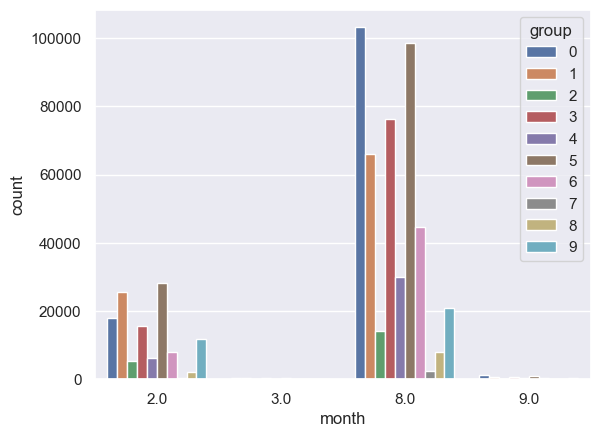

In [34]:
#graph number of tweets for each month for each group
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="month", hue="group", data=df)
plt.show()



In [3]:
df = pd.read_csv('raw_data_2.csv')

In [5]:
#group by group, language_2, month, day, hour, tweetcount, hod, and group_centroid_lat and group_centroid_lng and conc the text 
df_grouped = df.groupby(['group', 'language_2', 'month', 'day', 'hour', 'tweetcount', 'group_centroid_lat', 'group_centroid_lng']).agg({'text': ' '.join}).reset_index()

In [8]:
#create a new column called language and say english for 0, spanish for 1, and other for 2

df_grouped['language'] = df_grouped['language_2'].apply(lambda x: 'english' if x == 0 else ('spanish' if x == 1 else 'other')) 


In [14]:
#bin the tweetcount column into 1
bins = [-1, 10, 20, 30, 40, float('inf')]
labels = ['very low', 'low', 'medium', 'high', 'very high']
df_grouped['tweetcount_str'] = pd.cut(df_grouped['tweetcount'], bins=bins, labels=labels)


In [16]:
df_grouped

,group,language_2,month,day,hour,tweetcount,group_centroid_lat,group_centroid_lng,text,language,tweetcount_str
0,0,0,2.0,1.0,12.0,12,31.779174,-96.578990,ain’t felt this way inna min,english,low
1,0,0,2.0,1.0,12.0,35,31.779174,-96.578990,how many boys did you recruit,english,high
2,0,0,2.0,1.0,12.0,104,31.779174,-96.578990,damn sholl is a new month ain’t it,english,very high
3,0,0,2.0,1.0,13.0,7,31.779174,-96.578990,that’s being taken care of as we speak. gotta ...,english,very low
4,0,0,2.0,1.0,13.0,8,31.779174,-96.578990,lose 5lbs,english,very low
...,...,...,...,...,...,...,...,...,...,...,...
312155,9,2,9.0,1.0,6.0,27,42.463326,-91.440833,ベアが明後日気に入りそうな部屋を見に行く引越しの準備は89割完了もし気に入れば2週間後に引っ...,other,medium
312156,9,2,9.0,1.0,8.0,24,42.463326,-91.440833,happyhotelwinnipeg happyhotel,other,medium
312157,9,2,9.0,1.0,9.0,27,42.463326,-91.440833,goblin alert,other,medium
312158,9,2,9.0,1.0,10.0,7,42.463326,-91.440833,hihanna waste yelo oyata,other,very low


In [19]:
#add language of tweet, month, day, hour and tweetcount as features to text and call it text_with_features

df_grouped['text_with_features'] = df_grouped['text'] + '. ' + 'language is ' + df_grouped['language'] + ', ' + 'month is ' + df_grouped['month'].astype(str) + ', ' + 'day of month is ' + df_grouped['day'].astype(str) + ', ' + 'hour of day is ' + df_grouped['hour'].astype(str) + ', ' + 'this persons tweet count is ' + df_grouped['tweetcount_str'].astype(str) + '.'

In [23]:
#show full text 

pd.set_option('display.max_colwidth', None)

df_grouped['text_with_features']


0                                                                                                          ain’t felt this way inna min. language is english, month is 2.0, day of month is 1.0, hour of day is 12.0, this persons tweet count is low.
1                                                                                                        how many boys did you recruit. language is english, month is 2.0, day of month is 1.0, hour of day is 12.0, this persons tweet count is high.
2                                                                                              damn sholl is a new month ain’t it. language is english, month is 2.0, day of month is 1.0, hour of day is 12.0, this persons tweet count is very high.
3                                                   that’s being taken care of as we speak. gotta check out our roadmap some time.. language is english, month is 2.0, day of month is 1.0, hour of day is 13.0, this persons tweet count is very low.
4           

In [25]:
df_grouped_final = df_grouped[['group', 'text_with_features', 'group_centroid_lat', 'group_centroid_lng']]

In [26]:
#save this as csv file
df_grouped_final.to_csv('grouped_data_final.csv', index=False)


### FROM HERE IS LOADED RAW DATA

In [10]:
#load the raw data
df = pd.read_csv('raw_data.csv')

In [11]:
#put a period after every single text to make it a sentence
df['text'] = df['text'].apply(lambda x: x + '.')

In [12]:
df_grouped = df.groupby(['user_id', 'group', 'language', 'group_centroid_lat', 'group_centroid_lng', 'tweetcount'] )['text'].apply(' '.join).reset_index()


In [13]:
df_grouped

,user_id,group,language,group_centroid_lat,group_centroid_lng,tweetcount,text
0,0,5,0,41.403628,-75.249534,10,not gonna lie i really patted myself on the back for that one. been pretty dang happy with my ledger nano x so far.. for bitcoiners excited about the portman warner sinema amendment to the infrastructure bill the enemy of your enemy is not your friend here.. at this point the mutant apes have seen the same amount of trade volume as toy story 4 did in its box office opening weekend back in 2019. nothing though. the fact that it’s not at least qr code based is an absolute joke. the fact that the u.s. doesn’t have a digital proof of vaccination is an abject failure on so many levels.instead we’re going to get morally dishonest people forging paper ones and endangering others.actuallysounds about par for the course for the u.s.. yeah i wish there was another way but the other option is just mountains of annoyance.rippling had apis some interesting stuff with provisioning apps and ppo health care plans. that’s about it. trinet would have been my next choice.. thanks austin. susan always willing to do my part in helping my elected officials learn more about the technology world i live in every day. has helped me connect with a few in the past like and. a number of massive milestones for the team in less than a week. l2’s have arrived in a big way.. looking for portability or just something static.
1,1,0,0,31.779174,-96.578990,7,someday i hope to understand why chopper spends half his day noisily trying to knock a 5x7 art print of din djarin off the wall. someday.. i know you have this kind of closeness with your kitties. we are so lucky to have them.. meanwhile i’m working on some mirialan goodies. first order of business is finding luminara’s missing cape.. heeeeey doctor aphra fans. i’m working on a thing for y’all for the shop for next week. because murder droids deserve love too. and also because i found teeny tiny red rhinestones and some generic black protocol droids and couldn’t help myself.. i’m thisclose to writing a poetry collection that’s just beeps and boops.. this was my second alone christmas but it still felt weird. i think a lot of us are at our breaking points and it would be weird if we were doing okay right now. none of this is okay.. these probably won’t hit the shop until next week. but i love them..
2,2,5,0,41.403628,-75.249534,6,2020 was a millennium. i thought you were against selfrts. i’m “mattb” on . if you need an invite and we’re mutuals let me know. i’ve got 3 to give away.. the shades of pinks and purple are usually ugly as sin which doesn’t help.. cherry lush by tom ford a gift from.
3,2,5,1,41.403628,-75.249534,6,ah so findom.
4,3,2,0,47.398867,-120.804817,12,you will come around. just like the rest of us did.. 140 characters or less sometimes means ya gotta use 10¢ words.. welp. i guess now i will.wipes tears from eyes. but for folks who report in to me i thinks it’s fair to put the onus on me as their manager to find a timenavigate my calendar.. crayfish. there’s a bunch in some of the creeks in ggp.. or it is optimized for new twitter users fair enough but i’d love to see the numbers on subsequent follow behavior of legacy users.. jay frog. this was always the big miss with twitter blockchain hackweek projects but what about gdpr. i’m not gonna lie it was super sketchy.. they have the best twitter name ever.. twittervmteam batting close to 1000 on former interns become fulltime twitter engineers..
...,...,...,...,...,...,...,...
66633,41162,4,0,24.661466,-81.144745,6,kanjani..my dm had a bank account pin and stuff..y mara..i want my pin back. i would...i hate fighting for girls..i mean..ish..bona..entlek..mara..hoo..i was saying..ishh..ya mara i would..i need a girl to defend me from mashonisas once lenna.
66634,41162,4,1,24.661466,-81.144745,6,modimo o koatetse ba2. akere zintle onale zaka. what if he payed lobola ya 3million. mara hin ngani mara.
66635,41163,5,0,41.403628,-75.249534,7,in

In [15]:
#save as csv file
df_grouped.to_csv('grouped_data_may23.csv', index=False)


In [16]:
df_grouped

,user_id,group,language,group_centroid_lat,group_centroid_lng,tweetcount,text
0,0,5,0,41.403628,-75.249534,10,not gonna lie i really patted myself on the back for that one. been pretty dang happy with my ledger nano x so far.. for bitcoiners excited about the portman warner sinema amendment to the infrastructure bill the enemy of your enemy is not your friend here.. at this point the mutant apes have seen the same amount of trade volume as toy story 4 did in its box office opening weekend back in 2019. nothing though. the fact that it’s not at least qr code based is an absolute joke. the fact that the u.s. doesn’t have a digital proof of vaccination is an abject failure on so many levels.instead we’re going to get morally dishonest people forging paper ones and endangering others.actuallysounds about par for the course for the u.s.. yeah i wish there was another way but the other option is just mountains of annoyance.rippling had apis some interesting stuff with provisioning apps and ppo health care plans. that’s about it. trinet would have been my next choice.. thanks austin. susan always willing to do my part in helping my elected officials learn more about the technology world i live in every day. has helped me connect with a few in the past like and. a number of massive milestones for the team in less than a week. l2’s have arrived in a big way.. looking for portability or just something static.
1,1,0,0,31.779174,-96.578990,7,someday i hope to understand why chopper spends half his day noisily trying to knock a 5x7 art print of din djarin off the wall. someday.. i know you have this kind of closeness with your kitties. we are so lucky to have them.. meanwhile i’m working on some mirialan goodies. first order of business is finding luminara’s missing cape.. heeeeey doctor aphra fans. i’m working on a thing for y’all for the shop for next week. because murder droids deserve love too. and also because i found teeny tiny red rhinestones and some generic black protocol droids and couldn’t help myself.. i’m thisclose to writing a poetry collection that’s just beeps and boops.. this was my second alone christmas but it still felt weird. i think a lot of us are at our breaking points and it would be weird if we were doing okay right now. none of this is okay.. these probably won’t hit the shop until next week. but i love them..
2,2,5,0,41.403628,-75.249534,6,2020 was a millennium. i thought you were against selfrts. i’m “mattb” on . if you need an invite and we’re mutuals let me know. i’ve got 3 to give away.. the shades of pinks and purple are usually ugly as sin which doesn’t help.. cherry lush by tom ford a gift from.
3,2,5,1,41.403628,-75.249534,6,ah so findom.
4,3,2,0,47.398867,-120.804817,12,you will come around. just like the rest of us did.. 140 characters or less sometimes means ya gotta use 10¢ words.. welp. i guess now i will.wipes tears from eyes. but for folks who report in to me i thinks it’s fair to put the onus on me as their manager to find a timenavigate my calendar.. crayfish. there’s a bunch in some of the creeks in ggp.. or it is optimized for new twitter users fair enough but i’d love to see the numbers on subsequent follow behavior of legacy users.. jay frog. this was always the big miss with twitter blockchain hackweek projects but what about gdpr. i’m not gonna lie it was super sketchy.. they have the best twitter name ever.. twittervmteam batting close to 1000 on former interns become fulltime twitter engineers..
...,...,...,...,...,...,...,...
66633,41162,4,0,24.661466,-81.144745,6,kanjani..my dm had a bank account pin and stuff..y mara..i want my pin back. i would...i hate fighting for girls..i mean..ish..bona..entlek..mara..hoo..i was saying..ishh..ya mara i would..i need a girl to defend me from mashonisas once lenna.
66634,41162,4,1,24.661466,-81.144745,6,modimo o koatetse ba2. akere zintle onale zaka. what if he payed lobola ya 3million. mara hin ngani mara.
66635,41163,5,0,41.403628,-75.249534,7,in

In [6]:
#show text in entirety in pandas
pd.set_option('display.max_colwidth', None)
df['text'].sample(5)

69724                                                                                                                                                                                                                                         with our recall.
414764                                                                                                                                                                                                    18th place in the league while only playing 7 teams.
526665                                                     no evading questions are you for usa rules the world long arm jurisdiction ok trump's dismay ending and ordeal in presidential campaign manifest the big flaw across american democracy and value..
377444                                                                                                                                                                                                    así es por favor todos a respetan

### Group it just by language and hour